<a href="https://colab.research.google.com/github/vinodraj93/Bearing-Predictive-Maintenance/blob/master/Bearings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import numpy as np
import datetime
from sklearn import preprocessing
import sklearn
from sklearn.cluster import KMeans
from scipy import stats
import tensorflow as tf
from tensorflow.contrib.factorization import KMeans
from sklearn.decomposition import PCA
from IPython.display import clear_output
import os
from scipy.spatial import cKDTree
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [0]:
#@title
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from functools import reduce
findspark.init("spark-2.4.4-bin-hadoop2.7")
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext


In [0]:
#@title
# sc.setLogLevel("WARN")
log_txt=spark.read.text("/content/drive/My Drive/IMS/1st_test/*")
temp_var = log_txt.map(lambda k: k.split("\t"))
data=temp_var.toDF()
# log_df.withColumnRenamed('CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8')
oldColumns = data.schema.names
# newColumns = ["name", "age"]

data = data.selectExpr("_1 as CH1","_2 as CH2","_3 as CH3","_4 as CH4","_5 as CH5","_6 as CH6","_7 as CH7","_8 as CH8",)
# data.select(col(c), data.cast("float").alias(c) for c in data.columns)
data.describe()

In [0]:
Accel = []
Time = []
path, dirs, files = next(os.walk("/content/drive/My Drive/IMS/1st_test/"))
for filename in glob.glob('/content/drive/My Drive/IMS/1st_test/*'):
  clear_output(wait=True)
  data = pd.DataFrame(pd.read_csv(filename, sep = "\t",encoding = 'unicode_escape'))
  Accel.append(data)
  T = filename.strip('/content/drive/My Drive/Friends/Data/')
  Time.append(T)
  print('Progress: ',np.round(len(Accel)*100/
                              len(files),2),'%')



Progress:  100.0 %


In [0]:
bearings = []
for i, j in enumerate(Accel):
  clear_output(wait=True)
  print('Progress: ',np.round(i*100/(len(Accel)-1),2),'%',(i+1),'of',len(Accel))
  bearing = pd.DataFrame(Accel[i])
  bearing.loc[-1] = (Accel[i].columns)
  bearing.index = bearing.index + 1 
  bearing = bearing.sort_index()
  bearing.columns = ["CH1","CH2","CH3","CH4","CH5","CH6","CH7","CH8"]
  for column in bearing.columns:
    for ind, row in enumerate(bearing[column]):
      if type(row) == str:
#         print(bearing[column][ind])
        bearing[column][ind] = ".".join(row.split(".", 2)[:2])
#         print(bearing[column][ind])
  bearing = bearing.astype('float')
  T = Time[i].strip('IMS/1st_test/')
  Time1 = datetime.datetime.strptime("-".join(T.split(".")[0:3])+" "+":".join(T.split(".")[3:5]),'%Y-%m-%d %H:%M')
  bearing['DateTime'] = Time1
  bearings.append(bearing)

Progress:  100.0 % 2156 of 2156


In [0]:
#@title
sess = tf.Session()
num_pts = len(b4)
num_features = len(b4.columns)
k = 3
gen = 1

data_points = tf.Variable(b4)
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype=tf.int64))

rand_starts = np.array([b4.iloc[np.random.choice(len(b4))]
                        for _ in range(k)])
centroids = tf.Variable(rand_starts)

centroid_matrix = tf.reshape(tf.tile(centroids,[num_pts,1]),
                             [num_pts, k, num_features])
point_matrix = tf.reshape(tf.tile(data_points,[1,k]),[num_pts,
                                                      k,num_features])
distances = tf.reduce_sum(tf.square(point_matrix - centroid_matrix),reduction_indices=2)

centroid_group = tf.argmin(distances,1)

def data_group_avg(group_ids,data):
  sum_total=tf.unsorted_segment_sum(data,group_ids,3)
  num_total=tf.unsorted_segment_sum(tf.ones_like(data),group_ids,3)
  avg_by_group = sum_total/num_total
  return(avg_by_group)
means = data_group_avg(centroid_group,data_points)
update = tf.group(centroids.assign(means),cluster_labels.assign(centroid_group))
init = tf.global_variables_initializer()
sess.run(init)

for i in range(gen):
  print('Calculating gen {}'.format(i,gen))
  _, centroid_group_count = sess.run([update,centroid_group])
  group_count = []

for ix in range(k):
  group_count.append(np.sum(centroid_group_count==ix))
  print('Group counts: {}'.format(group_count))

[centers, assignments] = sess.run([centroids,cluster_labels])
def most_common(my_list):
  return(max(set(my_list),key=my_list.count))
label0 = most_common(list(assignments[0:2437121]))
label1 = most_common(list(assignments[2437121:4874241]))
label2 = most_common(list(assignments[4874241:7311361]))
group0_count = np.sum(assignments[0:2437121]==label0)
group1_count = np.sum(assignments[2437121:4874241]==label1)
group2_count = np.sum(assignments[4874241:7311361]==label2)
accuracy = (group0_count+group1_count+group2_count)/150
# print('Accuracy: {1:2}'.format(accuracy))



In [0]:
#@title
pca_model = PCA(n_components=2)
reduced_data = pca_model.fit_transform(b4)

reduced_centers = pca_model.transform(centers)


h=0.2
x_min, x_max = reduced_data[:,0].min()-1, reduced_data[:,0].max()+1
y_min, y_max = reduced_data[:,1].min()-1,reduced_data[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))


xx_pt = list(xx.ravel())
yy_pt = list(yy.ravel())
xy_pts = np.array([[x,y] for x,y in zip(xx_pt, yy_pt)])
mytree = cKDTree(reduced_centers)
dist, indexes = mytree.query(xy_pts)
indexes = indexes.reshape(xx.shape)
indexes

plt.clf()
plt.imshow(indexes,interpolation='nearest',
           extent=(xx.min(),xx.max(),yy.min(),yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto',origin='lower')

symbols=['o','^','D']
label_name = ['A','B','C']
for i in range(3):
  temp_group = reduced_data[(i*50):(50)*(i+1)]
  plt.plot(temp_group[:,0],temp_group[:,1],symbols[i],
           markersize=10, label=label_name[i])
  
plt.scatter(reduced_centers[:,0],reduced_centers[:,1],
            marker = 'x',s=169, linewidth =3,
            color='w',zorder=10)
plt.title("Graph")
# plt.xlim(x_min,x_max)
# plt.ylim(y_min,y_max)
plt.legend(loc='lower right')
plt.show()



In [0]:
#@title
full_data_x = b4
mnisttrainlabels = ['A','B','C','D']
# Parameters
num_steps = 1 # Total steps to train
batch_size = 1024 # The number of samples per batch
k = 4 # The number of clusters
num_classes = 4 # The 10 digits
num_features = 8 # Each image is 28x28 pixels

# Input images
X = tf.placeholder(tf.float32, shape=[7311360, num_features])
# Labels (for assigning a label to a centroid and testing)
Y = tf.placeholder(tf.float32, shape=[7311360, num_classes])

# K-Means Parameters
kmeans = KMeans(inputs=X, num_clusters=k, distance_metric='cosine',
                use_mini_batch=True)

# Build KMeans graph
training_graph = kmeans.training_graph()

if len(training_graph) > 6: # Tensorflow 1.4+
    (all_scores, cluster_idx, scores, cluster_centers_initialized,
     cluster_centers_var, init_op, train_op) = training_graph
else:
    (all_scores, cluster_idx, scores, cluster_centers_initialized,
     init_op, train_op) = training_graph

cluster_idx = cluster_idx[0] # fix for cluster_idx being a tuple
avg_distance = tf.reduce_mean(scores)

# Initialize the variables (i.e. assign their default value)
init_vars = tf.global_variables_initializer()

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars, feed_dict={X: full_data_x})
sess.run(init_op, feed_dict={X: full_data_x})

# Training
for i in range(1, num_steps + 1):
    _, d, idx = sess.run([train_op, avg_distance, cluster_idx],
                         feed_dict={X: full_data_x})
    print("Step %i, Avg Distance: %f" % (i, d))



# Assign a label to each centroid
# Count total number of labels per centroid, using the label of each training
# sample to their closest centroid (given by 'idx')
counts = np.zeros(shape=(k, num_classes))
for i in range(len(idx)):
    counts[idx[i]] = counts[idx[i]]+mnisttrainlabels[i]
# Assign the most frequent label to the centroid
labels_map = [np.argmax(c) for c in counts]
labels_map = tf.convert_to_tensor(labels_map)

# Evaluation ops
# Lookup: centroid_id -> label
cluster_label = tf.nn.embedding_lookup(labels_map, cluster_idx)
# Compute accuracy
correct_prediction = tf.equal(cluster_label, tf.cast(tf.argmax(Y, 1), tf.int32))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Test Model
test_x, test_y = mnist.test.images, mnist.test.labels
print("Test Accuracy:", sess.run(accuracy_op, feed_dict={X: test_x, Y: test_y}))

In [0]:
#@title
points_n = 200
clusters_n = 3
iteration_n = 100
 


points = tf.constant(np.random.uniform(0, 10, (points_n, 2)))
centroids = tf.Variable(tf.slice(tf.random_shuffle(points), [0, 0], [clusters_n, -1]))

 

points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)
 
distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)
 
means = []
for c in range(clusters_n):
    means.append(tf.reduce_mean(
    tf.gather(points, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1]))
 
new_centroids = tf.concat(means, 0)
 
update_centroids = tf.assign(centroids, new_centroids)
init = tf.global_variables_initializer()

 
with tf.Session() as sess:
  sess.run(init)
  for step in range(iteration_n):
    [_, centroid_values, points_values, assignment_values] = sess.run([update_centroids, centroids, points, assignments])
     
  print("centroids", centroid_values)
 
plt.scatter(points_values[:, 0], points_values[:, 1], c=assignment_values, s=50, alpha=0.5)
plt.plot(centroid_values[:, 0], centroid_values[:, 1], 'kx', markersize=15)
plt.show()


In [0]:
for int1,i in enumerate(bearing.columns):
  for int2, j in enumerate(bearing[i]):
    if type(j) == str:
      print([i,int2,j])

In [0]:
Channel = []

for i in bearings:
  for j in i.columns[:-1]:
    maxvib = max(i[j])
    minvib = min(i[j])
    meanvib =i[j].mean()
    varvib = np.var(i[j])
    SEM = stats.sem(i[j])
    freq = pd.DataFrame(i[j].value_counts()).reset_index()
    Commonfreq = freq.sort_values([j], ascending=False)['index'][0]
    Ch = j
    df = (maxvib,minvib,meanvib,varvib,SEM,Commonfreq,Ch,i['DateTime'][1])
    Channel.append(df)

  
  
  

Channel = pd.DataFrame(Channel,columns = ['Maxvib','Minvib','Mean',
                                          'STD','StdDevError',
                                          'Commonfreq','Channel','DateTime']).sort_values('DateTime',ascending=True)

Channel['HoursOPerated'] = ((((Channel['DateTime'].diff()).dt.seconds)/3600).cumsum()).fillna(0)
Channel['RUL'] = (((((Channel['DateTime'].diff()).dt.seconds)/60).cumsum()).fillna(0)).values[::-1]
Channel['RollingMean'] = \
pd\
.DataFrame(Channel\
           .groupby('Channel')['Mean']\
           .rolling(window=2)\
           .mean()\
           .fillna(0)\
           .reset_index()\
           .sort_values('level_1',ascending=True))\
           ['Mean']




In [0]:
b1 = Channel.iloc[0:44:12]
b2 = Channel.iloc[43::6]
b3 = pd.concat([b1,b2],ignore_index=True)
C = b3.sort_values('DateTime',ascending=True)

In [0]:
RadialLoad = {'Weight_on_CH1' : 0,
'Weight_on_CH2' : 0,
'Weight_on_CH3' : 6000,
'Weight_on_CH4' : 6000,
'Weight_on_CH5' : 6000,
'Weight_on_CH6' : 6000,
'Weight_on_CH7' : 0,
'Weight_on_CH8' : 0}



for ind,i in enumerate(["CH1","CH2","CH3","CH4","CH5","CH6","CH7","CH8"]):
    CH = Channel.loc[Channel['Channel'] == i].drop(columns=['RUL','DateTime','Channel']).reset_index()
    CH['Revolution']=np.arange(2000*60,(len(CH['index']))*2000*60+12000,2000*60)
    pd.get_dummies(CH, columns=['index'])
    weight = ("_".join(["Weight_on",i]))
    CH['Weight'] = RadialLoad[weight] 
    # X = np.array(CH1)
    # kmeans = KMeans(init='k-means++',n_clusters=2, random_state=0,n_init=10).fit(CH1)
    kmeans = sklearn.cluster.KMeans(n_clusters=3, random_state=0).fit(preprocessing.scale(CH))
    cent = pd.DataFrame(kmeans.cluster_centers_)
    cent.columns = CH.columns
    CH['Clusters'] = (kmeans.labels_)
   
    # CH['Clusters'] = CH['Clusters']
    df = CH.groupby('Clusters').count()['index'].sort_values(ascending=False).reset_index().rename(columns = {'index':'Count'})
    df.loc[[0,1,2],'Stress'] = ['Standard','LightStress','Damage']
    CH = pd.merge(CH,df,how='outer',left_on='Clusters',right_on='Clusters')
    CH = CH.drop(columns=['Clusters','index'])
    # plt.hist(CH1['Clusters'])
    # plt.xticks(np.arange(0,4,1))
    if ind == 0:
       CH1 = CH.sort_values('HoursOPerated', ascending=True)
    elif ind == 1:
       CH2 = CH.sort_values('HoursOPerated', ascending=True)
    elif ind == 2:
       CH3 = CH.sort_values('HoursOPerated', ascending=True)
    elif ind == 3:
       CH4 = CH.sort_values('HoursOPerated', ascending=True)
    elif ind == 4:
       CH5 = CH.sort_values('HoursOPerated', ascending=True)
    elif ind == 5:
       CH6 = CH.sort_values('HoursOPerated', ascending=True)
    elif ind == 6:
       CH7 = CH.sort_values('HoursOPerated', ascending=True)
    elif ind == 7:
       CH8 = CH.sort_values('HoursOPerated', ascending=True)

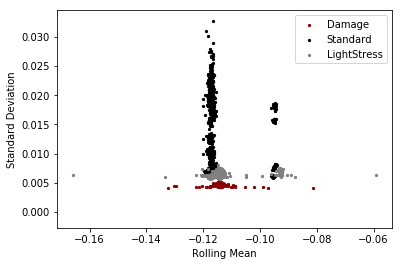

In [0]:
def clst(channel):    
    a = channel.loc[CH1['Stress'] == 'Damage', 'STD']
    b = channel.loc[CH1['Stress'] == 'Standard', 'STD']
    # c = ano.loc[ano['Stress'] == 'Normal', 'RollingMean']
    d = channel.loc[CH1['Stress'] == 'LightStress', 'STD']
    e = channel.loc[CH1['Stress'] == 'Damage', 'RollingMean']
    f = channel.loc[CH1['Stress'] == 'Standard', 'RollingMean']
    # g = ano.loc[ano['Stress'] == 'Normal', 'Revolution']
    h = channel.loc[CH1['Stress'] == 'LightStress', 'RollingMean']
    plt.scatter(e,a,label="Damage",color='darkred',s=5)
    plt.scatter(f,b,label="Standard",color='black',s=5)
    plt.scatter(h,d,label="LightStress",color='gray',s=5)
    plt.legend()
    plt.xlabel('Rolling Mean')
    plt.ylabel('Standard Deviation')
    plt.show()
    
clst(CH8)

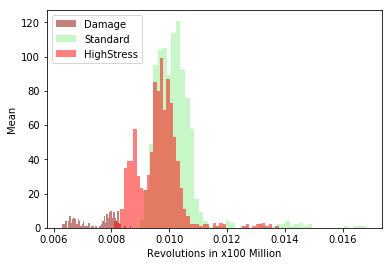

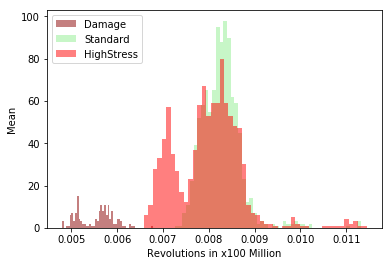

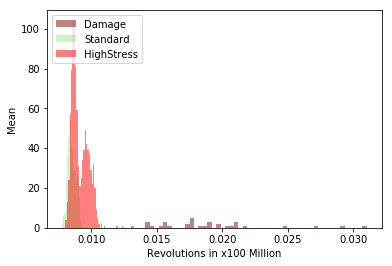

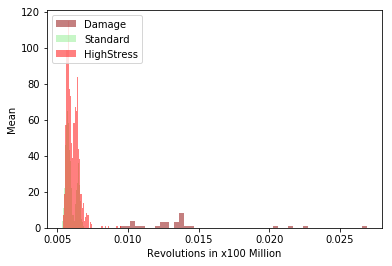

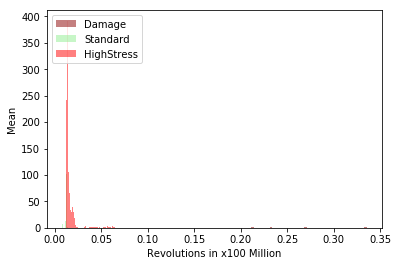

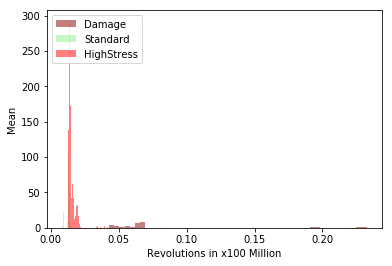

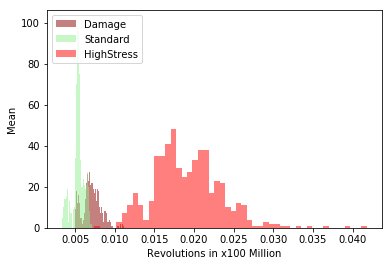

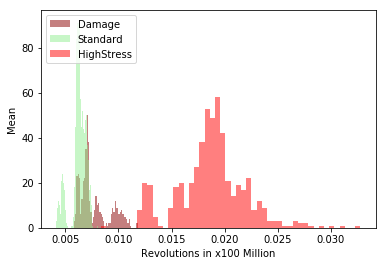

In [0]:
def plotan(ano):
    a = ano.loc[ano['Stress'] == 'Damage', 'STD']
    b = ano.loc[ano['Stress'] == 'Standard', 'STD']
    # c = ano.loc[ano['Stress'] == 'Normal', 'RollingMean']
    d = ano.loc[ano['Stress'] == 'LightStress', 'STD']
    e = ano.loc[ano['Stress'] == 'Damage', 'Revolution']
    f = ano.loc[ano['Stress'] == 'Standard', 'Revolution']
    # g = ano.loc[ano['Stress'] == 'Normal', 'Revolution']
    h = ano.loc[ano['Stress'] == 'LightStress', 'Revolution']
    # plt.figure(figsize=(10, 6))
    plt.hist(a,label='Damage',bins = 50, alpha=0.5, color = 'darkred')
    plt.hist(b,label='Standard',bins = 50, alpha=0.5, color = 'lightgreen')
    # plt.scatter(g,c,label='Normal',s=10, c='green')
    plt.hist(d,label='HighStress',bins = 50, alpha=0.5, color ='red')
    plt.legend(loc='upper left')
    plt.xlabel('Revolutions in x100 Million')
    plt.ylabel('Mean')
    plt.show()

plotan(CH1)
plotan(CH2)
plotan(CH3)
plotan(CH4)
plotan(CH5)
plotan(CH6)
plotan(CH7)
plotan(CH8)


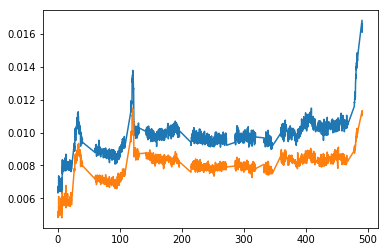

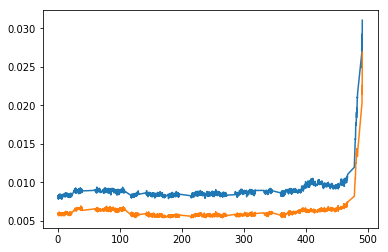

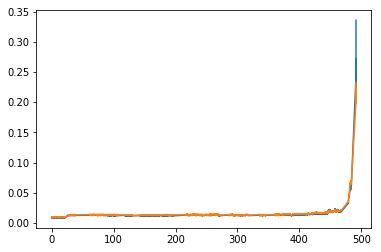

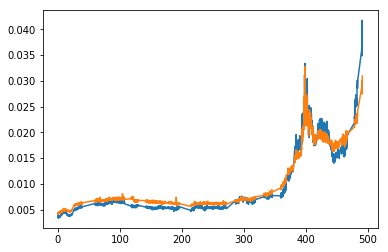

In [0]:
plt.plot(CH1['HoursOPerated'],CH1['STD'])
plt.plot(CH2['HoursOPerated'],CH2['STD'])
plt.show()
plt.plot(CH3['HoursOPerated'],CH3['STD'])
plt.plot(CH4['HoursOPerated'],CH4['STD'])
plt.show()

plt.plot(CH5['HoursOPerated'],CH5['STD'])
plt.plot(CH6['HoursOPerated'],CH6['STD'])
plt.show()

plt.plot(CH7['HoursOPerated'],CH7['STD'])
plt.plot(CH8['HoursOPerated'],CH8 ['STD'])
plt.show()

In [0]:
# split into input (X) and output (y) variables
models = []
for i in (CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8):
    X = i.iloc[:,:11]
    y = i.iloc[:,11]
    y = y.replace({"HighStress":3,"Standard":2,"Normal":1,"Damage":4})
    model = Sequential()
    model.add(Dense(11, input_dim=11, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, y, epochs=3, batch_size=10)
    _, accuracy = model.evaluate(X, y)
    print('Accuracy: %.2f' % (accuracy*100))
    models.append(model)
models






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/3
2156/2156 [==============================] - 6s 3ms/step - loss: 28.8571 - acc: 0.0000e+00
Epoch 2/3
2156/2156 [==============================] - 1s 404us/step - loss: 28.8571 - acc: 0.0000e+00
Epoch 3/3
2156/2156 [==============================] - 0s 55us/step
Accuracy: 0.00
Epoch 1/3
2156/2156 [==============================] - 1s 529us/step - loss: -12.6001 - acc: 0.4267
Epoch 2/3
2156/2156 [==============================] - 1s 395us/step - loss: -12.6001 - acc: 0.4267
Epoch 3/3
2156/2156 [==============================] - 0s 66us/step
Accuracy: 42.67
Epoch 1/3
2156/2156 [==============================] - 1s 562us/step - loss: 28.8571 - acc: 0.0000e+00
Epoch 2/3
2156/2156 [==============================] - 1s 379us/step - loss: 28.8571 - acc: 0.0000e+00
Epoch 3/3
2156/2156 [==============================] - 0s 74us/step
Accuracy: 0.00
Epoch 1/3
2156/2156 [===================

In [0]:
CH1

IndexError: ignored

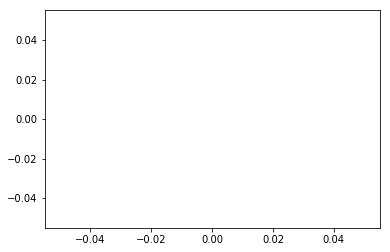

In [0]:
cent = cent.reset_index().melt(id_vars='index',value_vars=['Maxvib',
                                   'Minvib',
                                   'Mean',
                                   'STD',
                                   'StdDevError',
                                   'Commonfreq',
                                   'HoursOPerated',
                                   'RollingMean'],
          var_name = "Features")
f = cent.groupby(['Features']).agg({'value':'sum'}).reset_index()
g = pd.merge(cent,f,how='outer',left_on='Features',right_on='Features')
g['pct']=g['value_x']/g['value_y']
plt.bar(g.query('index==0')['Features'],g.query('index==0')['pct'],label='Cluster 0')
plt.bar(g.query('index==1')['Features'],g.query('index==1')['pct'],label='Cluster 1')
plt.bar(g.query('index==2')['Features'],g.query('index==2')['pct'],label='Cluster 2')
plt.bar(g.query('index==3')['Features'],g.query('index==3')['pct'],label='Cluster 3')
plt.gca()
plt.legend()
CH1

No handles with labels found to put in legend.


ValueError: ignored

<Figure size 432x288 with 1 Axes>

centroids [[7.47025047 7.48291979]
 [7.59450274 2.50649162]
 [2.46206193 7.58734829]
 [2.53277354 2.64827182]]


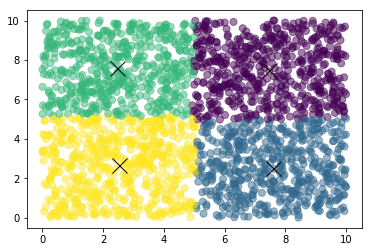

In [0]:
points_n = 200
clusters_n = 4
iteration_n = 100
 


points = tf.constant(np.random.uniform(0, 10, (len(CH1), 2)))
centroids = tf.Variable(tf.slice(tf.random_shuffle(points), [0, 0], [clusters_n, -1]))

 

points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)
 
distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)
 
means = []
for c in range(clusters_n):
    means.append(tf.reduce_mean(
    tf.gather(points, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1]))
 
new_centroids = tf.concat(means, 0)
 
update_centroids = tf.assign(centroids, new_centroids)
init = tf.global_variables_initializer()

 
with tf.Session() as sess:
  sess.run(init)
  for step in range(iteration_n):
    [_, centroid_values, points_values, assignment_values] = sess.run([update_centroids, centroids, points, assignments])
     
  print("centroids", centroid_values)
 
plt.scatter(points_values[:, 0], points_values[:, 1], c=assignment_values, s=50, alpha=0.5)
plt.plot(centroid_values[:, 0], centroid_values[:, 1], 'kx', markersize=15)
plt.show()

In [0]:
pd.DataFrame(new_centroids)

TypeError: ignored

In [0]:
# CH1['Time'].apply(lambda x : max(x)- min(x))
for i in (CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8):
  i['diff'] = (i['Time']-min(i['Time']))
  i['diff'] = i['diff'].apply(lambda x : x.seconds)
  

plt.scatter(CH1['diff'],CH1['Maxvib']-CH1['Minvib'],label="Bearing1",s=5,c='lightgrey')
plt.scatter(CH3['diff'],CH3['Maxvib']-CH3['Minvib'],label="Bearing2",s=5,c='silver')
plt.scatter(CH5['diff'],CH5['Maxvib']-CH5['Minvib'],label="Bearing3",s=5,c="darkred")
plt.scatter(CH7['diff'],CH7['Maxvib']-CH7['Minvib'],label="Bearing4",s=5,c='k')
plt.legend()
# plt.xticks(np.arange(0,100000,10000),rotation=45,ha='right')
# plt.yticks(np.arange(0,11,1))
plt.xlabel("Time (seconds)")
plt.ylabel("Vibration Range")
plt.title("Maximun - Minimum vibration")
plt.show()


plt.scatter(CH2['diff'],CH2['Maxvib']-CH2['Minvib'],label="Bearing1",s=5,c='lightgrey')
plt.scatter(CH4['diff'],CH4['Maxvib']-CH4['Minvib'],label="Bearing2",s=5,c='silver')
plt.scatter(CH6['diff'],CH6['Maxvib']-CH6['Minvib'],label="Bearing3",s=5,c="darkred")
plt.scatter(CH8['diff'],CH8['Maxvib']-CH8['Minvib'],label="Bearing4",s=5,c='k')
plt.legend()
# plt.xticks(np.arange(0,100000,10000),rotation=45,ha='right')
# plt.yticks(np.arange(0,11,1))
plt.xlabel("Time (seconds)")
plt.ylabel("Vibration Range")
plt.title("Maximun - Minimum vibration")
plt.show()

In [0]:
for i in (CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8):
  i['Range']=round(i['Maxvib']-i['Minvib'],2)
  df = pd.DataFrame(i.groupby('Range').size().reset_index())
  df.columns = ['Range','Count']
  plt.scatter(df['Count'],df['Range'],label="Bearing1")
  # plt.xticks(np.arange(0,30,2))
  plt.show()


# plt.bar(CH1['diff'],(CH1['Maxvib']-CH1['Minvib']),label="Bearing1")
# # plt.bar(CH3['diff'],(CH3['Maxvib']-CH3['Minvib']),label="Bearing2")
# # plt.bar(CH5['diff'],(CH5['Maxvib']-CH5['Minvib']),label="Bearing3")
# # plt.bar(CH7['diff'],(CH7['Maxvib']-CH7['Minvib']),label="Bearing4")
# plt.legend()
# # plt.xticks(np.arange(0,20000,5000),rotation=45,ha='right')
# # plt.yticks(np.arange(0,2,0.1))
# plt.xlabel("Time (seconds)")
# plt.ylabel("Vibration Range")
# plt.title("Maximun - Minimum vibration")
# plt.show()

In [0]:
CHM1 = []
CHM2 = []
CHM3 = []
CHM4 = []
CHM5 = []
CHM6 = []
CHM7 = []
CHM8 = []

for i in bearings:
  for ind, j in enumerate(i.columns): 
    if ind <= 7:
      meanvib =i[j].mean()
      varvib = np.var(i[j])
      SEM = stats.sem(i[j])
#       #i['Time'] = i['Time'].astype('datetime64[ns]')
      df = (meanvib,varvib,SEM, datetime.datetime.strptime(
                      "-".join((i['Time'][1]).split(".")[0:3])+" "+":".join((i['Time'][1]).split(".")[3:5])
                      ,'%Y-%m-%d %H:%M'))

      if j == 'CH1':
        CHM1.append(df)
      if j == 'CH2':
        CHM2.append(df)
      if j == 'CH3':
        CHM3.append(df)
      if j == 'CH4':
        CHM4.append(df)
      if j == 'CH5':
        CHM5.append(df)
      if j == 'CH6':
        CHM6.append(df)
      if j == 'CH7':
        CHM7.append(df)
      if j == 'CH8':
        CHM8.append(df)
    j 
  
  

CHM1 = (pd.DataFrame(CHM1,columns = ['Meanvib','STD','SEM','DateTime'])).sort_values('DateTime',ascending=True)
CHM2 = (pd.DataFrame(CHM2,columns = ['Meanvib','STD','SEM','DateTime'])).sort_values('DateTime',ascending=True)
CHM3 = (pd.DataFrame(CHM3,columns = ['Meanvib','STD','SEM','DateTime'])).sort_values('DateTime',ascending=True)
CHM4 = (pd.DataFrame(CHM4,columns = ['Meanvib','STD','SEM','DateTime'])).sort_values('DateTime',ascending=True)
CHM5 = (pd.DataFrame(CHM5,columns = ['Meanvib','STD','SEM','DateTime'])).sort_values('DateTime',ascending=True)
CHM6 = (pd.DataFrame(CHM6,columns = ['Meanvib','STD','SEM','DateTime'])).sort_values('DateTime',ascending=True)
CHM7 = (pd.DataFrame(CHM7,columns = ['Meanvib','STD','SEM','DateTime'])).sort_values('DateTime',ascending=True)
CHM8 = (pd.DataFrame(CHM8,columns = ['Meanvib','STD','SEM','DateTime'])).sort_values('DateTime',ascending=True)

for i in (CHM1,CHM2,CHM3,CHM4,CHM5,CHM6,CHM7,CHM8):
  i['diff'] = ((((i['DateTime'].diff()).dt.seconds)/60).cumsum()).fillna(0)
  i['RUL'] = i["diff"].values[::-1]
  # i['diff'] = i['diff'].cumsum()


In [0]:
bearingdf = pd.concat([CHM1,CHM2,CHM3,CHM4,CHM5,CHM6,CHM7,CHM8],ignore_index=True)
bearingdf
# bearingdf.drop(['STD','diff','Meanvib','DateTime'],1).corr()

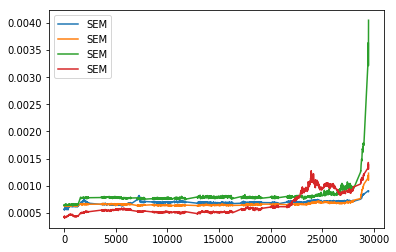

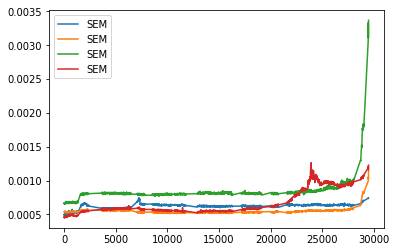

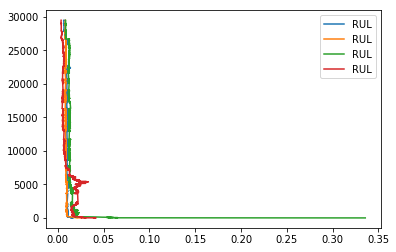

In [0]:
for i in (CHM1,CHM3,CHM5,CHM7):
  plt.plot(i['diff'],i['SEM'])
  plt.legend()
plt.show()

for i in (CHM2,CHM4,CHM6,CHM8):
  plt.plot(i['diff'],i['SEM'])
  plt.legend()
plt.show()

for i in (CHM1,CHM3,CHM5,CHM7):
  plt.plot(i['STD'],i['RUL'])
  plt.legend()
plt.show()

In [0]:
for i in (CHM1,CHM2,CHM3,CHM4,CHM5,CHM6,CHM7,CHM8):
  for ind,j in enumerate(i):
    mintime = i.iat[0, i.columns.get_loc('Time')]
    i['diff'] = (i['Date']-min(i['Date']))
    i['timediff'] = pd.to_timedelta((i.iat[ind, i.columns.get_loc('Time')])) - pd.to_timedelta(i.iat[0, i.columns.get_loc('Time')])
    i['diff'] = (i['diff'].apply(lambda x : x.days))*1440
    # (((i['Time']-mintime).apply(lambda x : x.seconds))/60)

# mintime = ((CHM1.sort_values('Date',ascending=True))[['Time']]).iloc[0]

In [0]:
CHV1 = []
CHV2 = []
CHV3 = []
CHV4 = []
CHV5 = []
CHV6 = []
CHV7 = []
CHV8 = []

for i in bearings:
  for j in i.columns:
    freq = pd.DataFrame(i[j].value_counts())\
    .reset_index()
    maxvib = freq.sort_values([j], ascending=False).iloc[0]
    minvib = freq.sort_values([j], ascending=True).iloc[0]
    
    df = (maxvib['index'],maxvib[j],minvib['index'],minvib[j], i['Time'][1])
    
    
    if j == 'CH1':
      CHV1.append(df)
    if j == 'CH2':
      CHV2.append(df)
    if j == 'CH3':
      CHV3.append(df)
    if j == 'CH4':
      CHV4.append(df)
    if j == 'CH5':
      CHV5.append(df)
    if j == 'CH6':
      CHV6.append(df)
    if j == 'CH7':
      CHV7.append(df)
    if j == 'CH8':
      CHV8.append(df)
  
  
  

CHV1 = pd.DataFrame(CHV1,columns = ['Maxvib','Maxfeq','Minvib','Minfeq','Time'])
CHV2 = pd.DataFrame(CHV2,columns = ['Maxvib','Maxfeq','Minvib','Minfeq','Time'])
CHV3 = pd.DataFrame(CHV3,columns = ['Maxvib','Maxfeq','Minvib','Minfeq','Time'])
CHV4 = pd.DataFrame(CHV4,columns = ['Maxvib','Maxfeq','Minvib','Minfeq','Time'])
CHV5 = pd.DataFrame(CHV5,columns = ['Maxvib','Maxfeq','Minvib','Minfeq','Time'])
CHV6 = pd.DataFrame(CHV6,columns = ['Maxvib','Maxfeq','Minvib','Minfeq','Time'])
CHV7 = pd.DataFrame(CHV7,columns = ['Maxvib','Maxfeq','Minvib','Minfeq','Time'])
CHV8 = pd.DataFrame(CHV8,columns = ['Maxvib','Maxfeq','Minvib','Minfeq','Time'])


#df = pd.concat((bearings[0:2]['CH1'])
# #   freq = pd.DataFrame(i['CH1'].value_counts())\
# #   .reset_index()



In [0]:
#@title
# plt.scatter(CHM1['Meanvib'],CHM1['STD'],s=5)
# plt.scatter(CHM2['Meanvib'],CHM2['STD'],s=5)
# plt.xlabel("Mean vibrations")
# plt.ylabel("Standard Deviation")
# plt.yticks(np.arange(0,0.35,0.05))
# plt.show()


# plt.scatter(CHM3['Meanvib'],CHM3['STD'],s=5)
# plt.scatter(CHM4['Meanvib'],CHM4['STD'],s=5)
# plt.xlabel("Mean vibrations")
# plt.ylabel("Standard Deviation")
# plt.yticks(np.arange(0,0.35,0.05))
# plt.show()

# plt.scatter(CHM5['Meanvib'],CHM5['STD'],s=5)
# plt.scatter(CHM6['Meanvib'],CHM6['STD'],s=5)
# plt.xlabel("Mean vibrations")
# plt.ylabel("Standard Deviation")
# plt.yticks(np.arange(0,0.35,0.05))
# plt.show()

# plt.scatter(CHM7['Meanvib'],CHM7['STD'],s=5)
# plt.scatter(CHM8['Meanvib'],CHM8['STD'],s=5)
# plt.xlabel("Mean vibrations")
# plt.ylabel("Standard Deviation")
# plt.yticks(np.arange(0,0.35,0.05))
# plt.show()

plt.scatter(CHM1['Meanvib'],CHM1['STD'],s=5,label = "Bearing 1")
plt.scatter(CHM3['Meanvib'],CHM3['STD'],s=5,label = "Bearing 2")
plt.scatter(CHM5['Meanvib'],CHM5['STD'],s=5,label = "Bearing 3")
plt.scatter(CHM7['Meanvib'],CHM7['STD'],s=5,label = "Bearing 4")
plt.xlabel("Mean vibrations")
plt.ylabel("Standard Deviation")
plt.legend(bbox_to_anchor=(1.3,1), loc='upper right', ncol=1)
plt.yticks(np.arange(0,0.4,0.05))
plt.xticks(np.arange(-0.25,0.15,0.05))
plt.show()

plt.scatter(CHM2['Meanvib'],CHM2['STD'],s=5,label = "Bearing 1")
plt.scatter(CHM4['Meanvib'],CHM4['STD'],s=5,label = "Bearing 2")
plt.scatter(CHM6['Meanvib'],CHM6['STD'],s=5,label = "Bearing 3")
plt.scatter(CHM8['Meanvib'],CHM8['STD'],s=5,label = "Bearing 4")
plt.xlabel("Mean vibrations")
plt.ylabel("Standard Deviation")
plt.legend(bbox_to_anchor=(1.3,1), loc='upper right', ncol=1)
plt.yticks(np.arange(0,0.4,0.05))
plt.xticks(np.arange(-0.25,0.15,0.05))
plt.show()

In [0]:
#@title
plt.plot(CH1['Maxvib']-CH1['Minvib'],c="deepskyblue",label="Bearing 1")
plt.plot(CH3['Maxvib']-CH3['Minvib'],c="royalblue",label="Bearing 2")
plt.plot(CH5['Maxvib']-CH5['Minvib'],c="blue",label="Bearing 3")
plt.plot(CH7['Maxvib']-CH7['Minvib'],c="navy",label="Bearing 4")
plt.legend(bbox_to_anchor=(1.3,1), loc='upper right')
# plt.yticks(np.arange(-4,5,step=1))
plt.show()

plt.plot(CH1['Minvib'],c="deepskyblue")
plt.plot(CH1['Maxvib'],c="deepskyblue")
plt.plot(CH3['Minvib'],c="royalblue")
plt.plot(CH3['Maxvib'],c="royalblue")
plt.plot(CH5['Minvib'],c="blue")
plt.plot(CH5['Maxvib'],c="blue")
plt.plot(CH7['Minvib'],c="navy")
plt.plot(CH7['Maxvib'],c="navy")
plt.subplots_adjust(hspace=0)
plt.legend(bbox_to_anchor=(1.25,1), loc='upper right', ncol=1)
plt.yticks(np.arange(-4,5,step=1))
plt.show()

plt.plot(CH2['Minvib'],c="peachpuff")
plt.plot(CH2['Maxvib'],c="peachpuff")
plt.plot(CH4['Minvib'],c="sandybrown")
plt.plot(CH4['Maxvib'],c="sandybrown")
plt.plot(CH6['Minvib'],c="orange")
plt.plot(CH6['Maxvib'],c="orange")
plt.plot(CH8['Minvib'],c="coral")
plt.plot(CH8['Maxvib'],c="coral")
plt.legend(bbox_to_anchor=(1.25,1), loc='upper right', ncol=1)
plt.yticks(np.arange(-4,5,step=1))
plt.show()

# plt.plot(CH3['Minvib'])
# plt.plot(CH3['Maxvib'])
# plt.yticks(np.arange(-4,5,step=1))
# plt.show()


# plt.scatter(CH1['Minvib'],CH1['Maxvib'],s=5)
# plt.scatter(CH2['Minvib'],CH2['Maxvib'],s=5)
# plt.xlabel("Minimum Vibrations")
# plt.ylabel("Maximum Vibrations")
# plt.show()

# plt.scatter(CH3['Minvib'],CH3['Maxvib'],s=5)
# plt.scatter(CH4['Minvib'],CH4['Maxvib'],s=5)
# plt.show()

# plt.scatter(CH5['Minvib'],CH5['Maxvib'],s=5)
# plt.scatter(CH6['Minvib'],CH6['Maxvib'],s=5)
# plt.show()

# plt.scatter(CH7['Minvib'],CH7['Maxvib'],s=5)
# plt.scatter(CH8['Minvib'],CH8['Maxvib'],s=5)
# plt.show()

# plt.plot(CH5['Minvib'])
# plt.plot(CH5['Maxvib'])
# plt.show()

# plt.plot(CH7['Minvib'])
# plt.plot(CH7['Maxvib'])
# plt.show()

In [0]:
#@title
plt.plot(CHM1['Meanvib'], label = 'CH1')
plt.plot(CHM2['Meanvib'], label ='CH2')
plt.xlabel('Time')
plt.ylabel('Mean Vibration')
plt.legend(loc='upper left')
plt.title('Bearing 1' )
plt.show()

plt.plot(CHM3['Meanvib'], label = 'CH3')
plt.plot(CHM4['Meanvib'], label = 'CH4')
plt.xlabel('Time')
plt.ylabel('Mean Vibration')
plt.legend(loc='upper left')
plt.title('Bearing 2' )
plt.show()


plt.plot(CHM5['Meanvib'], label = 'CH5')
plt.plot(CHM6['Meanvib'], label = 'CH6')
plt.xlabel('Time')
plt.ylabel('Mean Vibration')
plt.legend(loc='upper left')
plt.title('Bearing 3' )
plt.show()


plt.plot(CHM7['Meanvib'], label = 'CH7')
plt.plot(CHM8['Meanvib'], label = 'CH8')
plt.xlabel('Time')
plt.ylabel('Mean Vibration')
plt.legend(loc='upper left')
plt.title('Bearing 4' )
plt.show()

In [0]:
#@title
plt.boxplot([CHV1['Maxvib'],CHV2['Maxvib'],CHV3['Maxvib'],CHV4['Maxvib']],patch_artist=True)
plt.boxplot([CHV1['Minvib'],CHV2['Minvib'],CHV3['Minvib'],CHV4['Minvib']],patch_artist=True)
# plt.yticks(np.arange(-0.2,0.5,0.05))
plt.show()
plt.boxplot([CHV5['Maxvib'],CHV6['Maxvib'],CHV7['Maxvib'],CHV8['Maxvib']],patch_artist=True)
plt.boxplot([CHV5['Minvib'],CHV6['Minvib'],CHV7['Minvib'],CHV8['Minvib']],patch_artist=True)
# plt.yticks(np.arange(-0.3,0.4,0.05))
plt.show()
plt.boxplot(bearing['CH1'])

In [0]:
#@title
def vibplots(Channel,C):
  vibplot = plt.plot(Channel['Time'],Channel['Maxvib']-Channel['Minvib'],'b')
  plt.xlabel(C)
  plt.ylabel("Vibration Range")
  plt.yticks(np.arange(0,11,1))
  plt.show()
  return vibplot




# for i in (CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8):
#   plt.plot(i['Time'],i['Maxvib']-i['Minvib'],'b')
#   plt.show()
#   plt.plot(i['Time'],i['Maxvib']-i['Minvib'],'b')
#   plt.show()

In [0]:
#@title
a = vibplots(CH1,"CH1")

print(a)

In [0]:
#@title
v = vibplots(CH3,"CH3")
print(v)

In [0]:
#@title
v = vibplots(CH5,"CH5")
print(v)
h = vibplots(CH6,"CH6")
print(h)

In [0]:
#@title
v = vibplots(CH7,"CH7")
print(v)
h = vibplots(CH8,"CH8")
print(h)

In [0]:
#@title
def freq(i):
  plot = plt.hist(i['Maxvib'], bins=100)
  plt.xticks(np.arange(-0.2, -0.08, 0.04))
  plt.yticks(np.arange(0, 1100, 100))
  plt.show()
  return plot

print(freq(CHV1))
print(freq(CHV2))
print(freq(CHV3))
print(freq(CHV4))
print(freq(CHV5))
print(freq(CHV6))
print(freq(CHV7))
print(freq(CHV8))

In [0]:
#@title
# for i in bearing.columns:
plt.hist(bearing['CH1'],density=True, bins=100)
plt.hist(bearing['CH2'],density=True, bins=100)
# plt.hist(bearing['CH3'],density=True, bins=100)
# plt.hist(bearing['CH4'],density=True, bins=100)
# plt.hist(bearing['CH5'],density=True, bins=100)
# plt.hist(bearing['CH6'],density=True, bins=100)
# plt.hist(bearing['CH7'],density=True, bins=100)
plt.show()